In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.6 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import MultilabelAUROC

In [ ]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np
import math

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from matplotlib import rc
from pylab import rcParams


# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


# pytorch
import torch
import torchtext
from torchtext.data import get_tokenizer
import torch.nn as nn
from torch.optim import Adam, SGD, Adagrad
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter


%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

import warnings
warnings.filterwarnings("ignore")

# Build Model

Tokens -> Build vocab -> embedding -> Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
df = pd.read_csv('./drive/MyDrive/NLP_project/tokenized.csv')
df.dropna(inplace=True)

In [ ]:
df.head()

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation Why edits made username Hardcore M...,0,0,0,0,0,0
1,D aww He match background colour I seemingly s...,0,0,0,0,0,0
2,Hey man I really trying edit war It guy consta...,0,0,0,0,0,0
3,More I make real suggestion improvement I wond...,0,0,0,0,0,0
4,You sir hero Any chance remember page,0,0,0,0,0,0


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.05)
print('training :', train_df.shape)
print('validation :', val_df.shape)

training : (151553, 7)
validation : (7977, 7)


In [ ]:
LABEL_COLUMNS = df.columns.tolist()[1:]

In [ ]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

# resample to reduce training time 2 hrs -> 30 mins / epoch

train_df.shape, val_df.shape

((151553, 7), (7977, 7))

In [ ]:
train_df

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
128459,Proof Smashville error He say I committed pers...,0,0,0,0,0,0
107542,Location Refute largely residential authority ...,0,0,0,0,0,0
70981,No problem thanks keeping eye talk,0,0,0,0,0,0
36382,A piece free advice done Take week,0,0,0,0,0,0
42548,What type sterilization think affect taste milk,0,0,0,0,0,0
...,...,...,...,...,...,...,...
129151,Why revert edit I loss explain reverted edit P...,0,0,0,0,0,0
76512,I even given chance defend I even warning I po...,0,0,0,0,0,0
17562,A barnstar The Modest Barnstar In recognition ...,0,0,0,0,0,0
48491,Digeridie made fail They took aussie server mi...,0,0,0,0,0,0


# Dataloader

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comments = data_row.tokens
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        comments,
        add_special_tokens = True,
        max_length = self.max_token_len,
        return_token_type_ids = False,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    return dict(
      comments=comments, 
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )


In [ ]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer,256)
val_dataset = ToxicCommentsDataset(val_df, tokenizer, 256)

In [ ]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comments', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True)

In [ ]:
for x in train_loader:
    print(x['input_ids'].shape, x['attention_mask'].shape, x['labels'].shape)
    a = {'input_ids': x["input_ids"],
         'attention_mask': x['attention_mask']}
    print(a)
    break

torch.Size([64, 256]) torch.Size([64, 256]) torch.Size([64, 6])
{'input_ids': tensor([[  101,  5096, 10008,  ...,     0,     0,     0],
        [  101, 26316, 11336,  ...,     0,     0,     0],
        [  101,  1302,  2463,  ...,     0,     0,     0],
        ...,
        [  101,   146,  1189,  ...,     0,     0,     0],
        [  101,  1192,  8037,  ...,  1795,  2199,   102],
        [  101,  1109,  1440,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}


# model

In [ ]:
# check our batches
dataiter = iter(train_loader)
x = next(dataiter)

print('Sample batch size: ', x['input_ids'].size())   # batch_size, seq_length
print('Sample batch input: \n', x['input_ids'])
print()
print('Sample label size: ', x['labels'].size())   # batch_size
print('Sample label input: \n', x['labels'])

Sample batch size:  torch.Size([64, 256])
Sample batch input: 
 tensor([[  101,  5096, 10008,  ...,     0,     0,     0],
        [  101, 26316, 11336,  ...,     0,     0,     0],
        [  101,  1302,  2463,  ...,     0,     0,     0],
        ...,
        [  101,   146,  1189,  ...,     0,     0,     0],
        [  101,  1192,  8037,  ...,  1795,  2199,   102],
        [  101,  1109,  1440,  ...,     0,     0,     0]])

Sample label size:  torch.Size([64, 6])
Sample label input: 
 tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
 

In [ ]:

from torch import nn
from torch.nn import functional as F

class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 6)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X_batch):
        output = self.bert(X_batch["input_ids"], attention_mask=X_batch["attention_mask"])
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)

        return output

In [ ]:
model = BERTClassifier()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir runs

In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/toxic_comment_GloVe')

In [ ]:
from sklearn.metrics import accuracy_score
import gc


def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    target_names = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for batch in tqdm(val_loader):
            X = { 'input_ids': batch["input_ids"].to(device),
                  'attention_mask': batch['attention_mask'].to(device)}

            Y = batch['labels'].to(device)

            preds = model(X)

            Y = Y.to(torch.float32)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds)

            del X, Y, loss
            
        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)


        out = (Y_preds > 0.5).float() * 1
        tns, fps, fns, tps = 0, 0, 0, 0

        for i in range(6):
          tn, fp, fn, tp = confusion_matrix(Y_shuffled[:,i].cpu(), 
                                            out[:, i].cpu()).ravel()

          tns += tn
          fps += fp
          fns += fn
          tps += tp

          del tn, fp, fn, tp

        precision = tps / (tps + fps)
        recall = tps / (tps + fns)
        f1 = 2 * (precision * recall) / (precision + recall)

        auc = MultilabelAUROC(num_labels=6, average="macro", thresholds=None).to(device)

        print("Valid Loss : {:.3f} | Valid Acc : {:.3f} | Valid F1 : {:.3f} | Valid AUC : {:.3f}" .format(
            torch.tensor(losses).mean(), (tps+tns)/(tns+fps+fns+tps), f1, auc(out, Y_shuffled.to(torch.long))))
  
        del precision, recall

        return Y_shuffled, out, f1, auc(out, Y_shuffled.to(torch.long)), torch.tensor(losses).mean(), (tps+tns)/(tns+fps+fns+tps)

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10, patient=3):

    epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc = [], [], [], []
    epoch_tr_f1, epoch_vl_f1, epoch_tr_auc, epoch_vl_auc = [], [], [], []

    best_model = 100
    patient_counter = 0
    for i in range(1, epochs+1):
        print("Epochs : {}".format(i))
        Y_shuffled, Y_preds, losses= [],[],[]
        for batch in tqdm(train_loader):
            X = { 'input_ids': batch["input_ids"].to(device),
                  'attention_mask': batch['attention_mask'].to(device)}

            X, Y = X, batch['labels'].to(device)

            preds = model(X)
            Y = Y.to(torch.float32)

            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            del X, Y, loss, preds

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)


        tns, fps, fns, tps = 0, 0, 0, 0

        out = (Y_preds > 0.5).float() * 1
        for i in range(6):
          tn, fp, fn, tp = confusion_matrix(Y_shuffled[:,i].cpu().detach().numpy(), 
                                            out[:, i].cpu().detach().numpy()).ravel()

          tns += tn
          fps += fp
          fns += fn
          tps += tp

          del tn, fp, fn, tp
        precision = tps / (tps + fps)
        recall = tps / (tps + fns)
        f1 = 2 * (precision * recall) / (precision + recall)

        auc = MultilabelAUROC(num_labels=6, average="macro", thresholds=None).to(device)

        print("Train Loss : {:.3f} | Train Acc : {:.3f} | Train F1 : {:.3f} | Train AUC : {:.3f}" .format(
            torch.tensor(losses).mean(), (tps+tns)/(tns+fps+fns+tps), f1, auc(out, Y_shuffled.to(torch.long))))

        
        _, _, val_f1, val_auc, val_loss, val_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)
        print("-"*80)
        
        if val_loss <= best_model:
          best_model = val_loss
          patient_counter = 0
          torch.save(model.state_dict(), './drive/MyDrive/NLP_project/TCC_BERT-model.pt')
        else:
          patient_counter += 1
          print(f"The Val loss does not improve with {patient_counter} patient counter")

        epoch_tr_loss.append(torch.tensor(losses).mean())
        epoch_tr_acc.append((tps+tns)/(tns+fps+fns+tps))
        epoch_vl_loss.append(val_loss)
        epoch_vl_acc.append(val_acc)

        epoch_tr_f1.append(f1)
        epoch_tr_auc.append(auc(out, Y_shuffled.to(torch.long)))
        epoch_vl_f1.append(val_f1)
        epoch_vl_auc.append(val_auc)

        del precision, recall, f1


        if patient_counter == patient:
           break
      
    return [epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc,  epoch_tr_f1, epoch_vl_f1, epoch_tr_auc, epoch_vl_auc]

In [ ]:
from torch.optim import Adam
from transformers import logging
logging.set_verbosity_error()

epochs = 10
learning_rate = 1e-6 * 5

loss_fn = torch.nn.BCELoss().to(device)
model = BERTClassifier().to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

graph = TrainModel(model, 
                   loss_fn, 
                   optimizer, 
                   train_loader, 
                   val_loader, 
                   epochs)

Epochs : 1


100%|██████████| 2369/2369 [23:48<00:00,  1.66it/s]


Train Loss : 0.077 | Train Acc : 0.976 | Train F1 : 0.629 | Train AUC : 0.658


100%|██████████| 125/125 [00:24<00:00,  5.09it/s]


Valid Loss : 0.048 | Valid Acc : 0.983 | Valid F1 : 0.742 | Valid AUC : 0.685
--------------------------------------------------------------------------------
Epochs : 2


100%|██████████| 2369/2369 [23:47<00:00,  1.66it/s]


Train Loss : 0.041 | Train Acc : 0.985 | Train F1 : 0.779 | Train AUC : 0.731


100%|██████████| 125/125 [00:24<00:00,  5.09it/s]


Valid Loss : 0.045 | Valid Acc : 0.983 | Valid F1 : 0.758 | Valid AUC : 0.719
--------------------------------------------------------------------------------
Epochs : 3


100%|██████████| 2369/2369 [23:49<00:00,  1.66it/s]


Train Loss : 0.033 | Train Acc : 0.988 | Train F1 : 0.823 | Train AUC : 0.771


100%|██████████| 125/125 [00:24<00:00,  5.09it/s]


Valid Loss : 0.047 | Valid Acc : 0.983 | Valid F1 : 0.757 | Valid AUC : 0.740
--------------------------------------------------------------------------------
The Val loss does not improve with 1 patient counter
Epochs : 4


100%|██████████| 2369/2369 [23:48<00:00,  1.66it/s]


Train Loss : 0.025 | Train Acc : 0.991 | Train F1 : 0.871 | Train AUC : 0.820


100%|██████████| 125/125 [00:24<00:00,  5.09it/s]


Valid Loss : 0.052 | Valid Acc : 0.983 | Valid F1 : 0.737 | Valid AUC : 0.733
--------------------------------------------------------------------------------
The Val loss does not improve with 2 patient counter
Epochs : 5


100%|██████████| 2369/2369 [23:48<00:00,  1.66it/s]


Train Loss : 0.021 | Train Acc : 0.993 | Train F1 : 0.898 | Train AUC : 0.864


100%|██████████| 125/125 [00:24<00:00,  5.08it/s]


Valid Loss : 0.059 | Valid Acc : 0.982 | Valid F1 : 0.727 | Valid AUC : 0.745
--------------------------------------------------------------------------------
The Val loss does not improve with 3 patient counter


In [ ]:
model.load_state_dict(torch.load('./drive/MyDrive/NLP_project/TCC_BERT-model.pt'))

<All keys matched successfully>

# Test

In [ ]:
test = pd.read_csv('./drive/MyDrive/NLP_project/test_tokenized.csv')
test.dropna(inplace=True)

In [ ]:
test_dataset = ToxicCommentsDataset(test, tokenizer,256)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=4, pin_memory=True)


In [ ]:
loss_fn = torch.nn.BCELoss().to(device)
model.to(device)
pred, true, _, _, _, _= CalcValLossAndAccuracy(model, loss_fn, test_loader)

tns, fps, fns, tps = 0, 0, 0, 0
for i in range(6):
  tn, fp, fn, tp = confusion_matrix(pred[:,i].cpu(), 
                                    true[:, i].cpu()).ravel()

  tns += tn
  fps += fp
  fns += fn
  tps += tp
  print(i)
  print(tp, fp)
  print(fn, tn)

  del tn, fp, fn, tp
print('-'*40)
print(tps, fps)
print(fns, tns)

100%|██████████| 993/993 [03:12<00:00,  5.15it/s]


Valid Loss : 0.069 | Valid Acc : 0.971 | Valid F1 : 0.659 | Valid AUC : 0.724
0
5184 4234
905 53228
1
87 90
280 63094
2
2826 1517
864 58344
3
0 0
211 63340
4
2335 1216
1092 58908
5
195 50
517 62789
----------------------------------------
10627 7107
3869 359703


In [ ]:
precision = tps / (tps + fps)
recall = tps / (tps + fns)
f1 = 2 * (precision * recall) / (precision + recall)

print("{:.2f}, {:.2f}, {:.2f}".format(precision, recall, f1))

0.60, 0.73, 0.66


In [ ]:
def get_sigle_prediciton(model, val_loader):
  target_names = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
  with torch.no_grad():
        for batch in val_loader:
            X = { 'input_ids': batch["input_ids"].to(device),
                  'attention_mask': batch['attention_mask'].to(device)}

            X, Y = X, batch['labels'].to(device)

            preds = model(X)


  return preds, Y
      
def get_prediction(comment):
  test_dataset = ToxicCommentsDataset(comment, tokenizer,256)
  test_aloader = DataLoader(test_dataset, batch_size=64, num_workers=4, pin_memory=True)

  pred, true = get_sigle_prediciton(model, test_aloader)

  return pred, true

In [ ]:
test[test['identity_hate'] == 1]

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
24,DJ Robinson gay hell suck dick much,1.0,0.0,1.0,0.0,1.0,1.0
138,HE IS A GHAY ASS FUCKER,1.0,0.0,1.0,0.0,1.0,1.0
159,Random Deletion Deleted xanax bar fuck mah nig...,1.0,0.0,1.0,0.0,1.0,1.0
200,WARNING This first warning If stop gay raped i...,1.0,0.0,1.0,0.0,1.0,1.0
331,willeys u male willey u likley gay lol,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
63408,ZANGIEF IS NOT GAY HEY LINDSAY DUDE IS YOU ARE...,1.0,0.0,1.0,0.0,1.0,1.0
63503,WTF Who F put userbox saying I faggot I I supp...,1.0,0.0,1.0,0.0,1.0,1.0
63638,b style font size px CALVIN IS A FUCKING NIGGE...,1.0,1.0,1.0,0.0,1.0,1.0
63639,I meet one day stab death prepared say goodbye...,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
test.iloc[test.index == 331].tokens.values[0]

'willeys u male willey u likley gay lol'

In [ ]:
a = 331
pred, a = get_prediction(test.iloc[test.index == a])
print(pred)
print(a)


tensor([[0.9798, 0.0513, 0.6411, 0.0290, 0.7403, 0.2881]], device='cuda:0')
tensor([[1., 0., 0., 0., 0., 1.]], device='cuda:0')


In [ ]:
def predict_random(comment):
  def get_prediciton(model, val_loader):
      with torch.no_grad():
          for batch in tqdm(val_loader):
            X = { 'input_ids': batch["input_ids"].to(device),
                  'attention_mask': batch['attention_mask'].to(device)}

            X, Y = X, batch['labels'].to(device)

            preds = model(X)
      
      return preds
        
  df = pd.DataFrame({'tokens': comment, 
                     'toxic': 0,
                     'severe_toxic':0,
                     'obscene': 0,
                     'threat': 0,
                     'insult':0,
                     'identity_hate':0
                     }, index=[0])
  
  test_dataset = ToxicCommentsDataset(df, tokenizer,256)
  test_aloader = DataLoader(test_dataset, batch_size=64, num_workers=4, pin_memory=True)

  return get_prediciton(model, test_aloader)

In [ ]:
predict_random("No arrogant self serving immature idiot Get right")


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


tensor([[0.9545, 0.0184, 0.3463, 0.0228, 0.7743, 0.0201]], device='cuda:0')

In [ ]:

epoch_tr_loss = graph[0]
epoch_vl_loss = graph[1]
epoch_tr_acc = graph[2]
epoch_vl_acc = graph[3]
epoch_tr_f1 = graph[4]
epoch_vl_f1 = graph[5]
epoch_tr_auc = [x.item() for x in graph[6]]
epoch_vl_auc = [x.item() for x in graph[7]]

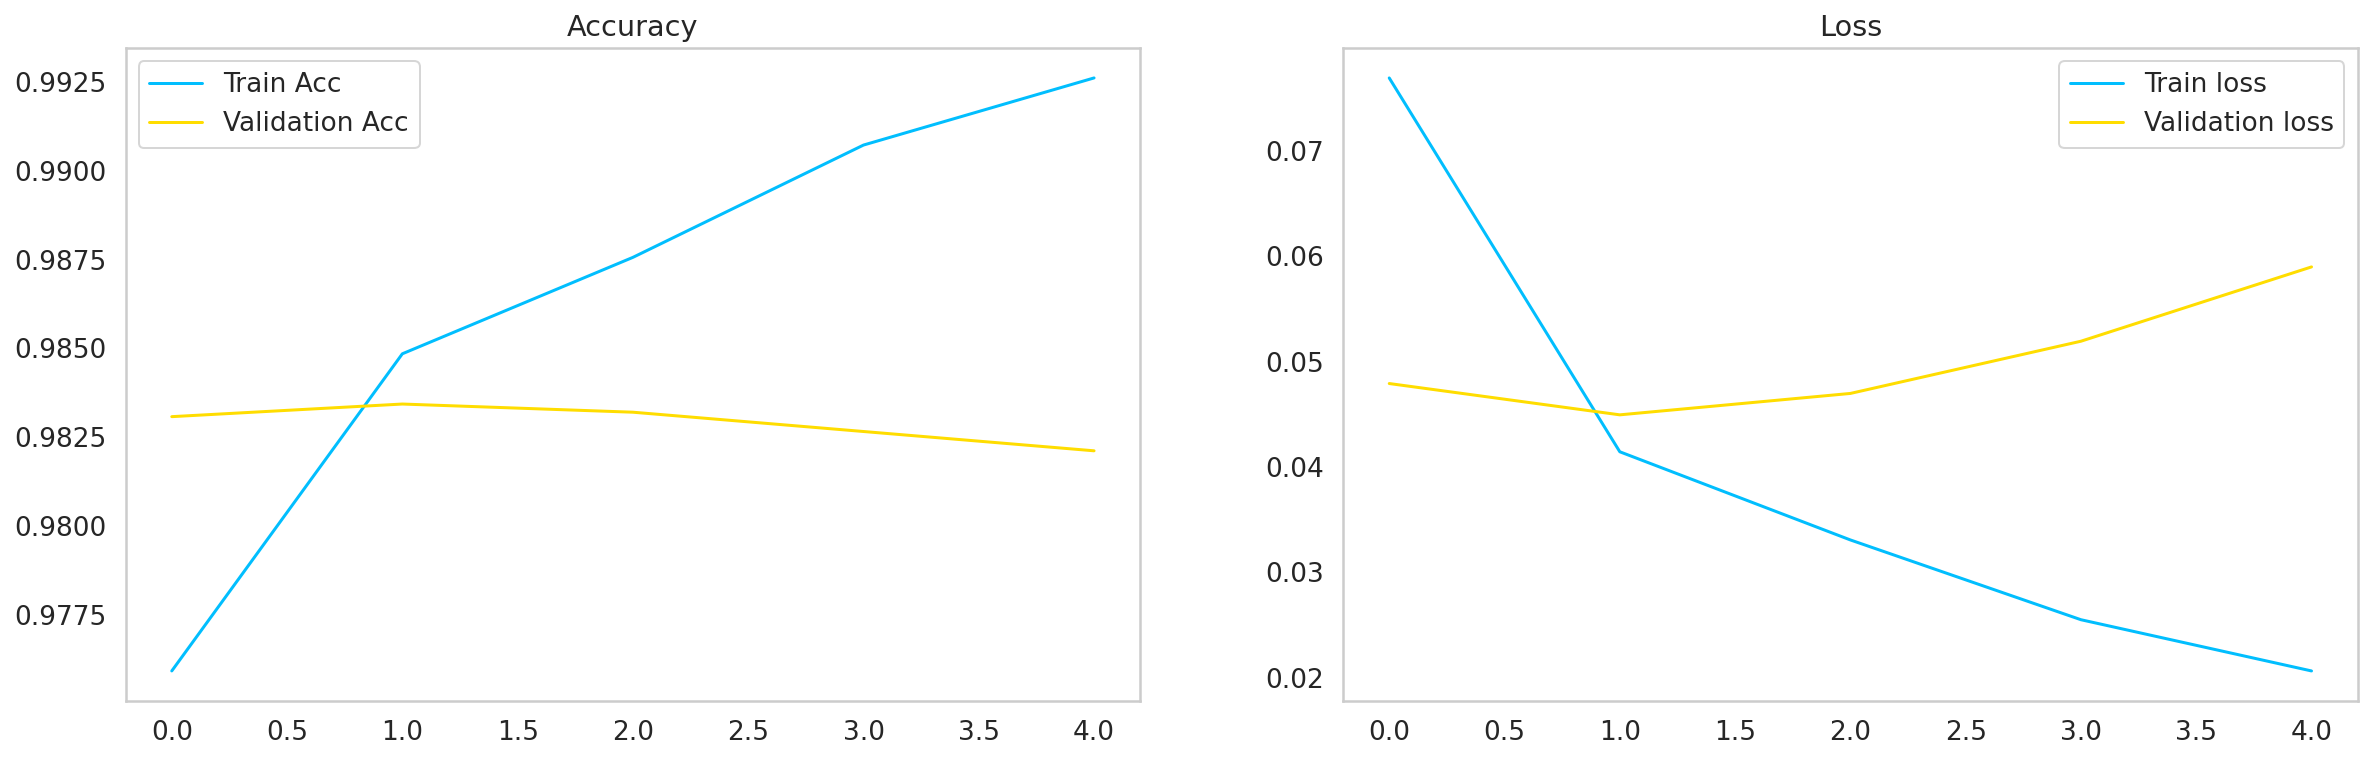

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

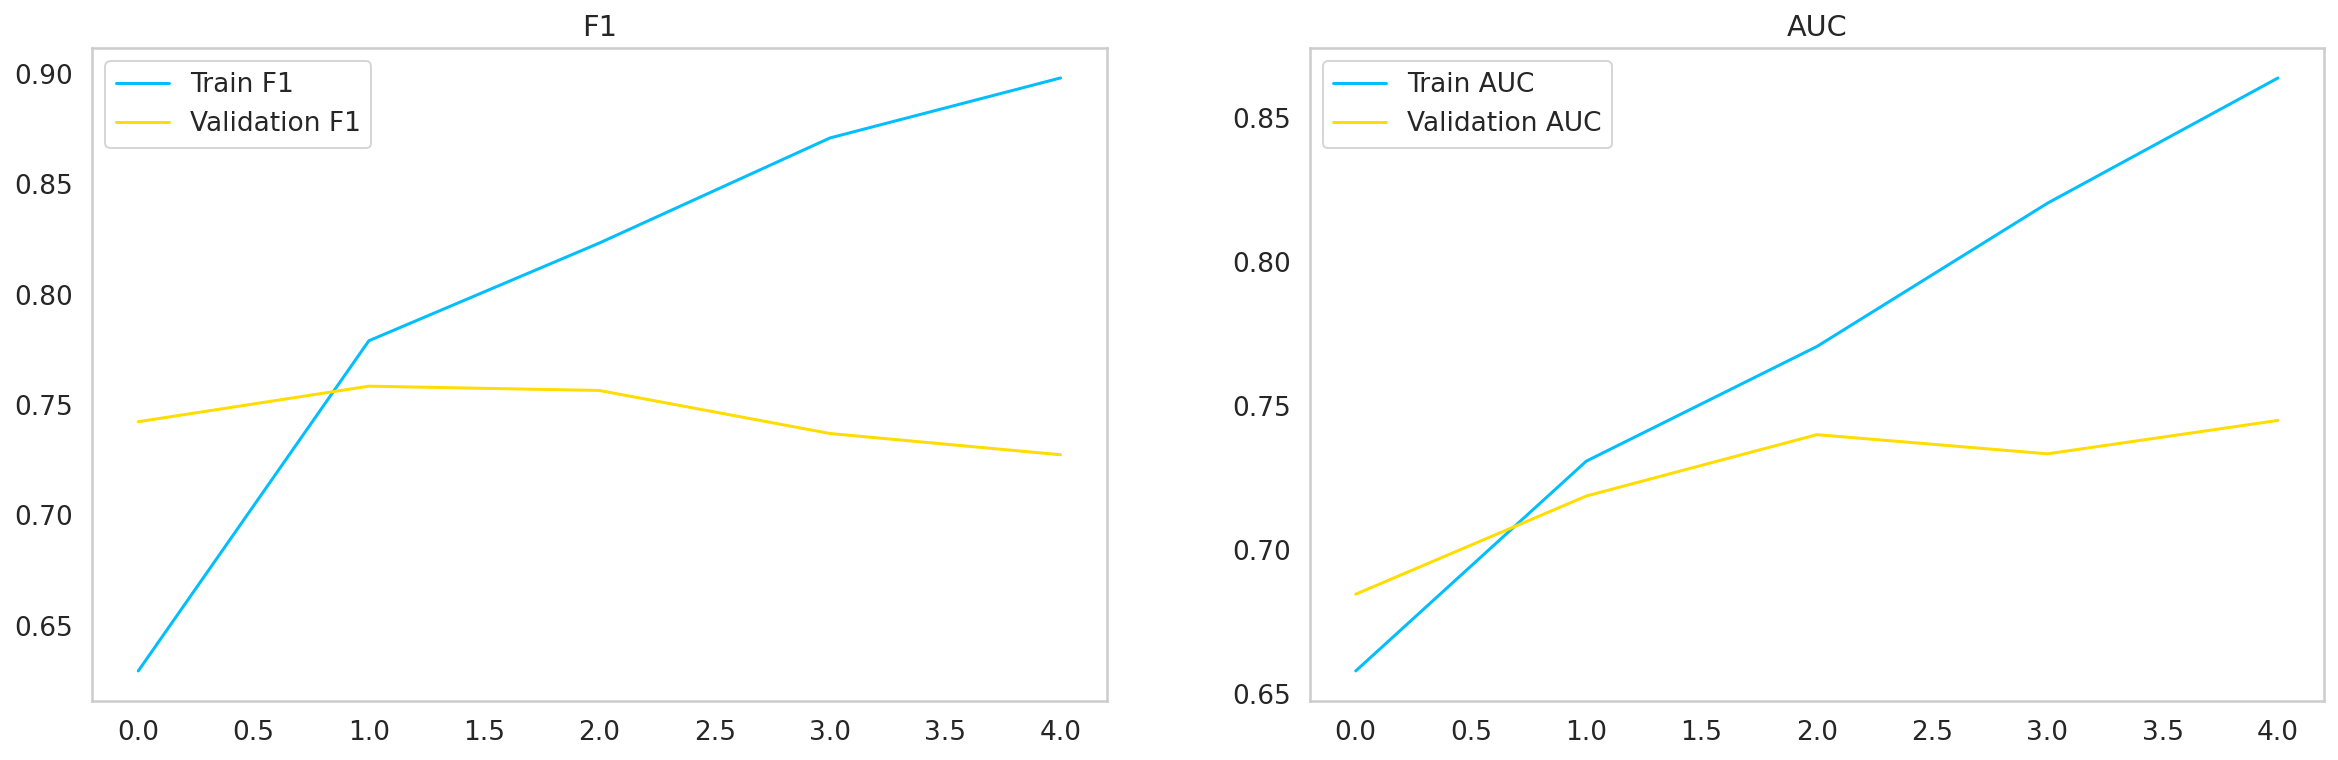

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_f1, label='Train F1')
plt.plot(epoch_vl_f1, label='Validation F1')
plt.title("F1")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_auc, label='Train AUC')
plt.plot(epoch_vl_auc, label='Validation AUC')
plt.title("AUC")
plt.legend()
plt.grid()

plt.show()